# Probabilistic Classification

Here I illustrate probabilistic classification with two examples from Chapter 5 of

> Simon Rogers and Mark Girolami (2013), *A First Course in Machine Learning*, Chapman and Hall/CRC.

The first uses a Gaussian mixture to classify points in the plane, while the second uses a multinomial mixture to classify texts.

In [1]:
# Import all the things
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import linalg
from scipy.stats import multivariate_normal

## Classification with Gaussian mixtures

This first example involves synthetic data, three clouds of points that we model with a mixture of three multivariate normal distributions. That is, we say
$P(X | C=j)$
is a multivariate normal

Another way to describe this is to say that we use *Gaussian class-conditional distributions*.

In [2]:
# Read the data
RG_Gcc = pd.read_csv("rogers_gaussian_class_conditional.csv")
RG_Gcc.head()

,x1,x2,class
0,1.110672,-2.107862,1
1,-0.549837,0.094261,1
2,-0.038220,1.882927,1
3,0.055461,-0.613890,1
4,0.587017,-1.206709,1


### Constructing the class-conditional Gaussians

In [7]:
# Compute the mean and covariance matrix for each class separately
# and store them in a list of dictionaries. We begin by
# building a list of empty dictionaries with one entry for each class
nClasses = 3
classifierParams = [dict() for j in range(nClasses)]

In [8]:
classifierParams

[{}, {}, {}]

In [9]:
# Now we fill the dictionaries up
totalNpoints = RG_Gcc.shape[0]  # number of rows in the dataframe

for j in range(nClasses):
    crntClass = j + 1  # Class labels start from 1, j from 0.

    # Select those rows with data about the current class
    boolIdx = RG_Gcc["class"] == crntClass # Filter the data has same class
    crntData = RG_Gcc[boolIdx] # store the filtered data
    crntNpoints = crntData.shape[0]  # number of rows in crnt data

    # Get the x coordinates into a numpy array
    crntXmat = crntData.iloc[:, 0:2].values # except the class 

    # Compute the mean and covariance of the data as well
    # as the weight for this component, which we take to
    # be the fraction of the data that falls into crntClass
    classifierParams[j]["weight"] = crntNpoints / totalNpoints
    classifierParams[j]["mean"] = np.mean(crntXmat, axis=0)  # Does column means
    classifierParams[j]["covar"] = np.cov(
        crntXmat, rowvar=False
    )  # Treats rows as points

# Look at the results to make sure they're sane.
classifierParams

[{'weight': 0.3333333333333333,
  'mean': array([-0.11414439,  0.11170333]),
  'covar': array([[1.02366573, 0.09161203],
         [0.09161203, 1.5595529 ]])},
 {'weight': 0.3333333333333333,
  'mean': array([1.8161242 , 2.54446472]),
  'covar': array([[ 1.766211  , -0.10638287],
         [-0.10638287,  1.10266129]])},
 {'weight': 0.3333333333333333,
  'mean': array([ 1.63560726, -2.13877498]),
  'covar': array([[1.15425031, 1.08308411],
         [1.08308411, 1.23283903]])}]

#### Plotting the points with confidence ellipses for the components

The function takes a mean, a covariance and a confidence level $0 < c < 1$ and draws an ellipse that encloses $c$ of the probability mass for a Gaussian with the given mean and covariance.

In [10]:
def confidenceEllipse(conf, mean, covar, nPts=100):
    # Work out the desired coords for a standard
    # two-dimensional normal
    confR = math.sqrt(-2.0 * math.log(1 - conf)) 
    theta = np.linspace(0, 2 * math.pi, endpoint=True, num=nPts + 1)
    x = confR * np.cos(theta)
    y = confR * np.sin(theta)
    xyMat = np.vstack((x, y)).T

    # Now transform them to fit the user-specified normal.
    xyMat = np.matmul(xyMat, linalg.sqrtm(covar))

    muX = mean[0] * np.ones(nPts + 1)
    muY = mean[1] * np.ones(nPts + 1)
    muMat = np.vstack((muX, muY)).T

    return np.add(xyMat, muMat)

We then make the plot and add a number of confidence ellipses for each class's Gaussian, to show their extent.

In [11]:
# Set the limits for the plots
xMin = -3
xMax = 6
yMin = -6
yMax = 6

# Choose some colours
cmap = plt.get_cmap("Set2")
setPal = cmap([1, 2, 3])

Text(0.5, 1.0, 'Class-conditional Gaussians')

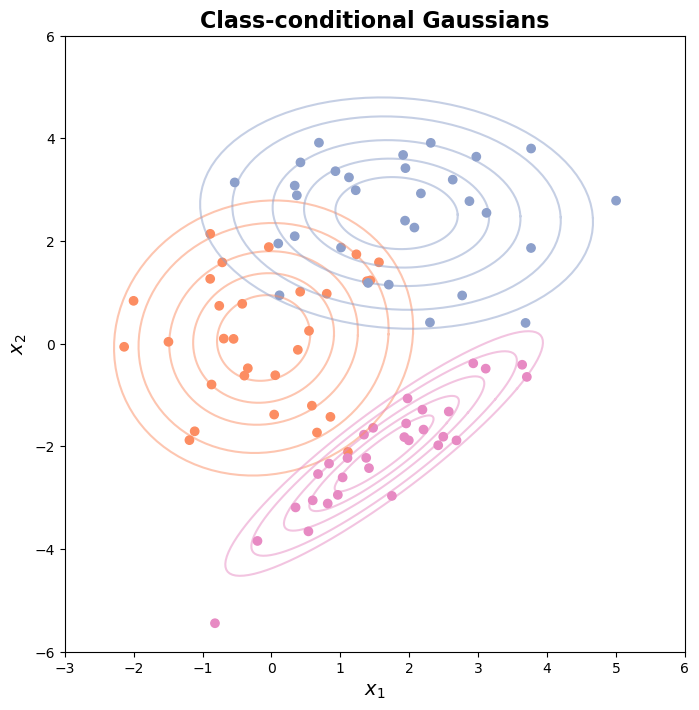

In [12]:
# Plot the points
plt.figure(figsize=[8, 8])
plt.scatter(RG_Gcc["x1"], RG_Gcc["x2"], c=setPal[RG_Gcc["class"] - 1])
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)

# Add ellipses
confLevels = np.array([20, 40, 60, 80, 90]) / 100.0
for j in range(nClasses):
    crntMean = classifierParams[j]["mean"]
    crntCovar = classifierParams[j]["covar"]
    for conf in confLevels:
        # Plot a translucent curve
        xyMat = confidenceEllipse(conf, crntMean, crntCovar)
        plt.plot(xyMat[:, 0], xyMat[:, 1], "-", color=setPal[j], alpha=0.5)

# Add titles and display
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Class-conditional Gaussians", fontsize=16, fontweight="bold")

### Classifying new points

First we define a function to compute probabilities of class membership, then we use it to:
* draw contour plots of $P( C=j | x, D)$
* classify a number of test points

In [15]:
def membershipProbs(x, classParams):
    # Count the number of classes and
    # initialise the result
    nClasses = len(classifierParams)
    probs = np.zeros(nClasses)

    # Now evaluate each of the weighted,
    # class-conditional densities at x.
    for j in range(nClasses):
        crntMean = classifierParams[j]["mean"]
        crntCovar = classifierParams[j]["covar"]
        crntWeight = classifierParams[j]["weight"]
        probs[j] = crntWeight * multivariate_normal(crntMean, crntCovar).pdf(x)

    # Normalise the probabilities so they add up to one.
    probs = probs / np.sum(probs)
    return probs

In [16]:
# Try a test point, just to see that the function works
membershipProbs(np.array([1, 1]), classifierParams)

array([6.54583551e-01, 3.45416449e-01, 3.16679565e-14])

#### Drawing contour maps of probability-of-class-membership

To make contour maps one needs to evaluate the function in question on a grid.

In [9]:
nTicks = 101
xVals = np.linspace(start=xMin, stop=xMax, num=nTicks)
yVals = np.linspace(start=yMin, stop=yMax, num=nTicks)

# Build a 3D matrix zMat such that zMat[i,j,k] is the
# probability that the point (xVals[j], yVals[i])
# is in class k.
zMat = np.zeros((nTicks, nTicks, nClasses))
for i in range(nTicks):
    for j in range(nTicks):
        crntPt = np.array([xVals[j], yVals[i]])
        probs = membershipProbs(crntPt, classifierParams)
        for k in range(nClasses):
            zMat[i, j, k] = probs[k]

We then make three plots, one for each class, showing how the probability of class membership varies across the region.

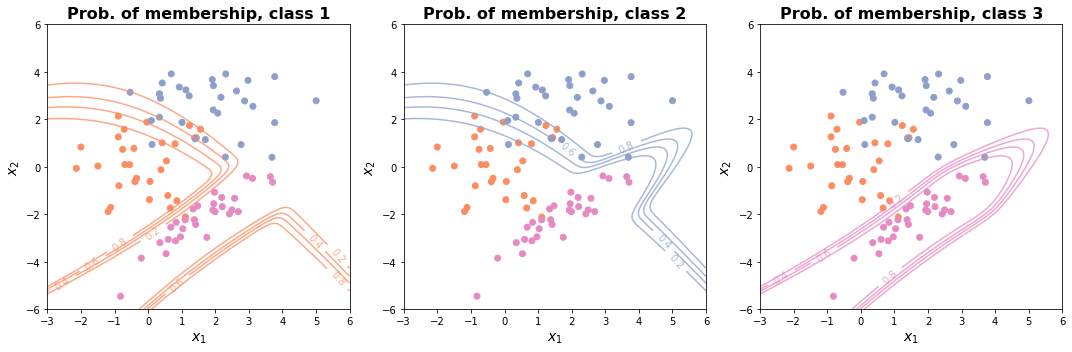

In [10]:
# Set up the plot.
pcmFig, pcmAxes = plt.subplots(1, nClasses, figsize=[5 * nClasses, 5])

# Plot each class separately
for j in range(nClasses):
    # Plot the contours first
    crntContours = pcmAxes[j].contour(
        xVals, yVals, zMat[:, :, j], levels=4, colors=[setPal[j]], alpha=0.75
    )

    # Then add labels
    pcmAxes[j].clabel(crntContours, inline=1, fontsize=10)

    # Then add the points
    pcmAxes[j].scatter(RG_Gcc["x1"], RG_Gcc["x2"], c=setPal[RG_Gcc["class"] - 1])

    # And finally set the labels
    pcmAxes[j].set_xlabel("$x_1$", fontsize=14)
    pcmAxes[j].set_ylabel("$x_2$", fontsize=14)
    pcmAxes[j].set_title(
        "Prob. of membership, class " + str(j + 1), fontsize=16, fontweight="bold"
    )

plt.tight_layout()  # Avoid overlapping labels

#### Compute probability of class membership at a few test points

In [11]:
# Choose some test points.
xyTest = np.array([[-2, -2], [1, 1.5], [2, 0], [4, -4]])
xyTest

array([[-2. , -2. ],
       [ 1. ,  1.5],
       [ 2. ,  0. ],
       [ 4. , -4. ]])

Text(0.5, 1.0, 'Classifying test points')

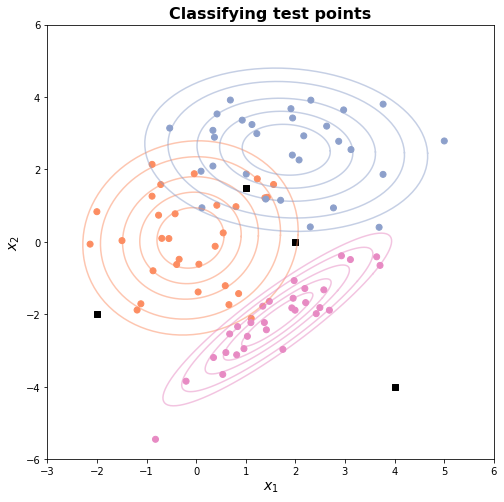

In [12]:
# Plot the training points as coloured dots ...
plt.figure(figsize=[8, 8])
plt.scatter(RG_Gcc["x1"], RG_Gcc["x2"], c=setPal[RG_Gcc["class"] - 1])
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)

# then add the test points as black squares ...
plt.scatter(xyTest[:, 0], xyTest[:, 1], c="black", marker="s")

# and finally, the ellipses.
confLevels = np.array([20, 40, 60, 80, 90]) / 100.0
for j in range(nClasses):
    crntMean = classifierParams[j]["mean"]
    crntCovar = classifierParams[j]["covar"]
    for conf in confLevels:
        # Plot a translucent curve
        xyMat = confidenceEllipse(conf, crntMean, crntCovar)
        plt.plot(xyMat[:, 0], xyMat[:, 1], "-", color=setPal[j], alpha=0.5)

# Add titles and display
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Classifying test points", fontsize=16, fontweight="bold")

Below we compute the probabilities of class membership for the test points. Notice that because the Gaussian for class 3 (purply-pink points and ellipses) is so highly concentrated  (has small, narrow confidence ellipses), and that for class 1 (orange points and ellipses) is so weakly concentrated, the point at lower right (coords (4, -4)), gets assigned to class 1, even though the center of that class is further away. 

In [13]:
# Find probability of class membership for the test points
nTestPts = xyTest.shape[0]
probMat = np.zeros((nTestPts, nClasses))
for j in range(nTestPts):
    probMat[j, :] = membershipProbs(xyTest[j, :], classifierParams)

# Print out a nicely-formatted version of probMat
print(np.array2string(probMat, formatter={"float_kind": lambda x: "%.3f" % x}))

[[1.000 0.000 0.000]
 [0.424 0.576 0.000]
 [0.689 0.302 0.009]
 [0.996 0.004 0.000]]
